# Tensorgrad Demo: Training a CNN on CIFAR-10

This notebook demonstrates the TensorGrad framework: a NumPy/CuPy-based autograd engine with a PyTorch-like API, implemented from scratch.\
The goal is clarity, correctness, and educational value rather than raw performance.

The notebook showcases:
- The Tensorgrad autograd engine
- Custom Dataset and Dataloader
- Model definition
- Training loop with optimizer and scheduler

In [1]:
import sys
import pickle
import tarfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

ROOT = Path.cwd().resolve().parents[0]
sys.path.insert(0, str(ROOT))

from tensorgrad.tensor import Tensor, no_grad
from tensorgrad.data import TensorDataset, RandomHorizontalFlipDataset, DataLoader
from tensorgrad.nn import (
    Sequential, Conv2d, ReLU, CrossEntropyLoss,
    Dropout, Linear, Flatten, MaxPool2d,
)
from tensorgrad.optim import AdamW
from tensorgrad.training import fit
from tensorgrad.lr_scheduler import ReduceLROnPlateau

In [2]:
DATA_DIR = ROOT / "demos" / "data" / "cifar-10"
FILENAME = DATA_DIR / "cifar-10-python.tar.gz"
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

DATA_DIR.mkdir(parents=True, exist_ok=True)

def download(url: str, dest: Path) -> None:
    if dest.exists():
        return
    print(f"Downloading {url} -> {dest}")
    urllib.request.urlretrieve(url, dest)
    print("Download complete!")

def extract(filename: Path, dir: Path) -> None:
    extracted_dir = dir / "cifar-10-batches-py"
    if extracted_dir.exists():
        return
    print("Extracting files...")
    with tarfile.open(filename, 'r:gz') as tar:
        tar.extractall(dir, filter='data')
    print("Extraction complete!")

def load_cifar_batch(file: Path):
    with file.open("rb") as f:
        batch = pickle.load(f, encoding="bytes")
    data = batch[b"data"].reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    labels = np.array(batch[b"labels"], dtype=np.int64)
    return data, labels

def load_cifar10(data_dir: Path):
    cifar_dir = data_dir / "cifar-10-batches-py"

    # Load training data
    train_data = []
    train_labels = []
    for i in range(1, 6):
        data, labels = load_cifar_batch(cifar_dir / f"data_batch_{i}")
        train_data.append(data)
        train_labels.append(labels)

    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    # Load validation data (test set is used for validation)
    val_data, val_labels = load_cifar_batch(cifar_dir / "test_batch")

    return train_data, train_labels, val_data, val_labels

In [3]:
download(URL, FILENAME)
extract(FILENAME, DATA_DIR)

Download complete!
Extracting files...
Extraction complete!


In [4]:
train_data, train_labels, val_data, val_labels = load_cifar10(DATA_DIR)

# normalize data
mean = train_data.mean(axis=(0, 2, 3), keepdims=True)
std  = train_data.std(axis=(0, 2, 3), keepdims=True) + 1e-7
train_data = (train_data - mean) / std
val_data  = (val_data - mean) / std

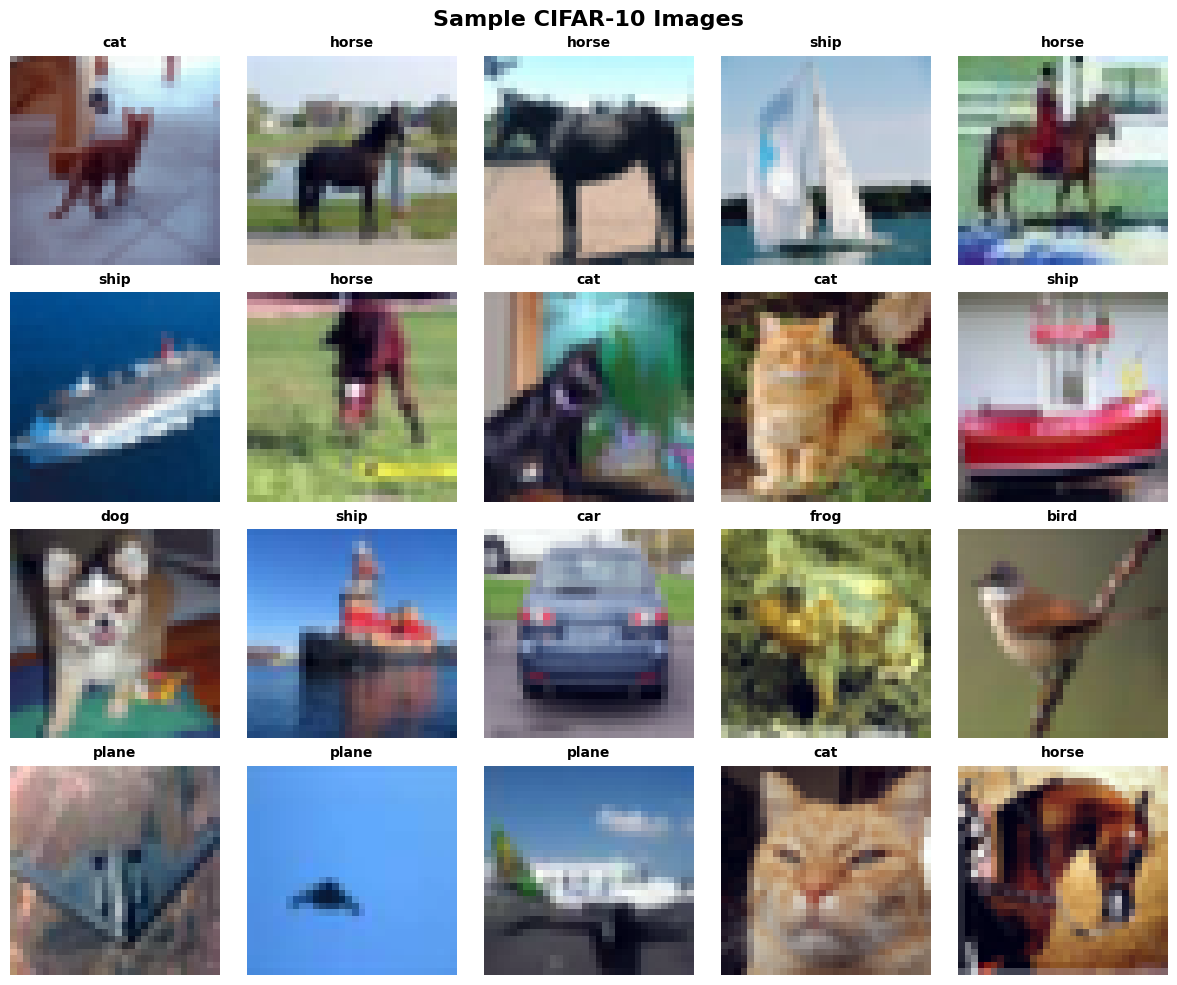

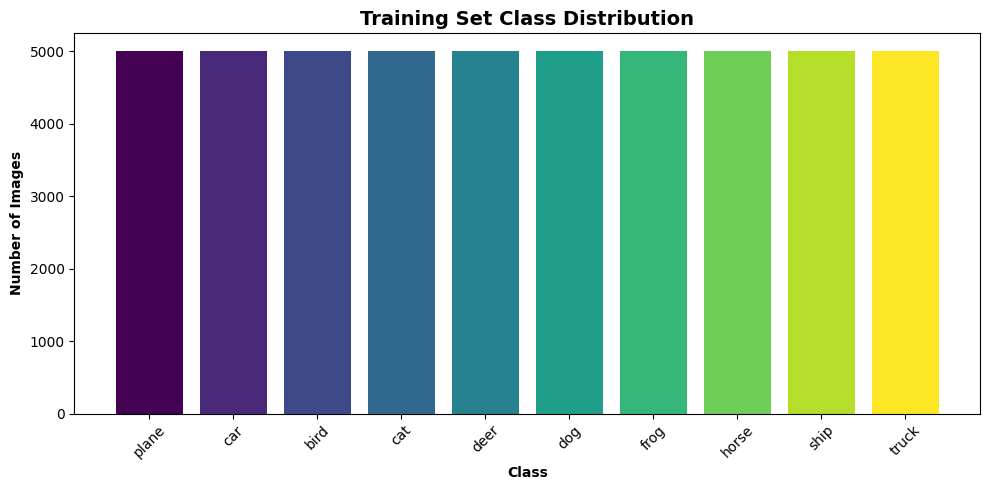

In [5]:
plt.style.use('default')

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

# Visualize Sample Images
def show_images(images, labels, title):
    fig, axes = plt.subplots(4, 5, figsize=(12, 10))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for idx, ax in enumerate(axes.flat):
        img = images[idx].transpose(1, 2, 0)
        img = (img - img.min()) / (img.max() - img.min())
        ax.imshow(img)
        ax.set_title(f'{classes[labels[idx]]}', fontsize=10, fontweight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show random samples
random_indices = np.random.choice(len(train_data), 20, replace=False)
show_images(train_data[random_indices], train_labels[random_indices], 'Sample CIFAR-10 Images')

# Class distribution
fig, ax = plt.subplots(figsize=(10, 5))
unique, counts = np.unique(train_labels, return_counts=True)
colors = plt.cm.viridis(np.linspace(0, 1, 10))
ax.bar(range(len(classes)), counts, color=colors)
ax.set_xlabel('Class', fontweight='bold')
ax.set_ylabel('Number of Images', fontweight='bold')
ax.set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=45)
plt.tight_layout()
plt.show()

In [6]:
device = "cuda"      # should be cpu or cuda

X_train = Tensor(train_data, requires_grad=False, device=device)
y_train = Tensor(train_labels, requires_grad=False, device=device)

X_val = Tensor(val_data, requires_grad=False, device=device)
y_val = Tensor(val_labels, requires_grad=False, device=device)

train_ds = TensorDataset(X_train, y_train)
train_ds = RandomHorizontalFlipDataset(train_ds, p=0.5)
val_ds  = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, drop_last=True)
val_loader  = DataLoader(val_ds, batch_size=512, shuffle=False)

In [7]:
# CNN Model
model = Sequential(
    Conv2d(3, 16, 3, padding=1),
    ReLU(),
    MaxPool2d(2, 2),

    Conv2d(16, 32, 3, padding=1),
    ReLU(),
    MaxPool2d(2, 2),

    Conv2d(32, 64, 3, padding=1),
    ReLU(),
    MaxPool2d(2, 2),

    Flatten(),
    Dropout(0.4),
    Linear(64 * 4 * 4, 10),
)

model.to(device=device);

In [8]:
# Train the Model
loss_fn = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=2,
    threshold=1e-3,
    min_lr=1e-6,
)

num_epochs = 30

history = fit(
    model=model,
    train_loader=train_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    val_loader=val_loader,
    scheduler=scheduler,
)

Epoch 1/30, lr=0.001 Train: 1.7524 (50.95%)  Val: 1.3793 (51.09%)
Epoch 2/30, lr=0.001 Train: 1.3578 (58.73%)  Val: 1.1923 (58.35%)
Epoch 3/30, lr=0.001 Train: 1.2100 (62.60%)  Val: 1.0989 (61.55%)
Epoch 4/30, lr=0.001 Train: 1.1253 (66.10%)  Val: 1.0183 (64.32%)
Epoch 5/30, lr=0.001 Train: 1.0659 (68.01%)  Val: 0.9728 (65.91%)
Epoch 6/30, lr=0.001 Train: 1.0154 (69.23%)  Val: 0.9418 (67.03%)
Epoch 7/30, lr=0.001 Train: 0.9734 (70.65%)  Val: 0.9086 (68.57%)
Epoch 8/30, lr=0.001 Train: 0.9460 (72.35%)  Val: 0.8802 (69.09%)
Epoch 9/30, lr=0.001 Train: 0.9159 (72.68%)  Val: 0.8565 (70.20%)
Epoch 10/30, lr=0.001 Train: 0.8980 (73.35%)  Val: 0.8411 (70.81%)
Epoch 11/30, lr=0.001 Train: 0.8721 (74.52%)  Val: 0.8191 (71.45%)
Epoch 12/30, lr=0.001 Train: 0.8509 (74.02%)  Val: 0.8408 (71.01%)
Epoch 13/30, lr=0.001 Train: 0.8382 (75.87%)  Val: 0.8043 (72.08%)
Epoch 14/30, lr=0.001 Train: 0.8323 (76.07%)  Val: 0.7863 (72.31%)
Epoch 15/30, lr=0.001 Train: 0.8164 (75.26%)  Val: 0.8124 (71.75%)
Epoc

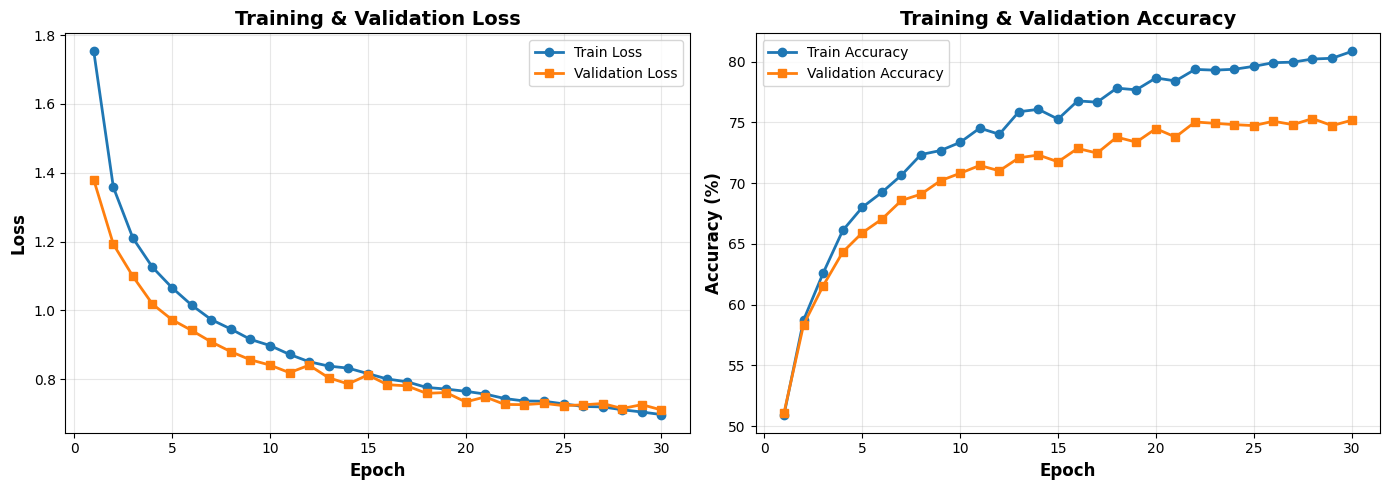

In [9]:
# Plot Training Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, num_epochs+1)

# Loss plot
ax1.plot(epochs, history["train_loss"], 'o-', label='Train Loss', linewidth=2, markersize=6)
ax1.plot(epochs, history["val_loss"], 's-', label='Validation Loss', linewidth=2, markersize=6)
ax1.set_xlabel('Epoch', fontweight='bold', fontsize=12)
ax1.set_ylabel('Loss', fontweight='bold', fontsize=12)
ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs, history["train_acc"], 'o-', label='Train Accuracy', linewidth=2, markersize=6)
ax2.plot(epochs, history["val_acc"], 's-', label='Validation Accuracy', linewidth=2, markersize=6)
ax2.set_xlabel('Epoch', fontweight='bold', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=12)
ax2.set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Generate Confusion Matrix
model.eval()
confusion = np.zeros((10, 10), dtype=int)

with no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)

        pred = outputs.data.argmax(axis=1)
        true = labels.data.astype(int)

        for t, p in zip(true, pred):
            confusion[int(t), int(p)] += 1

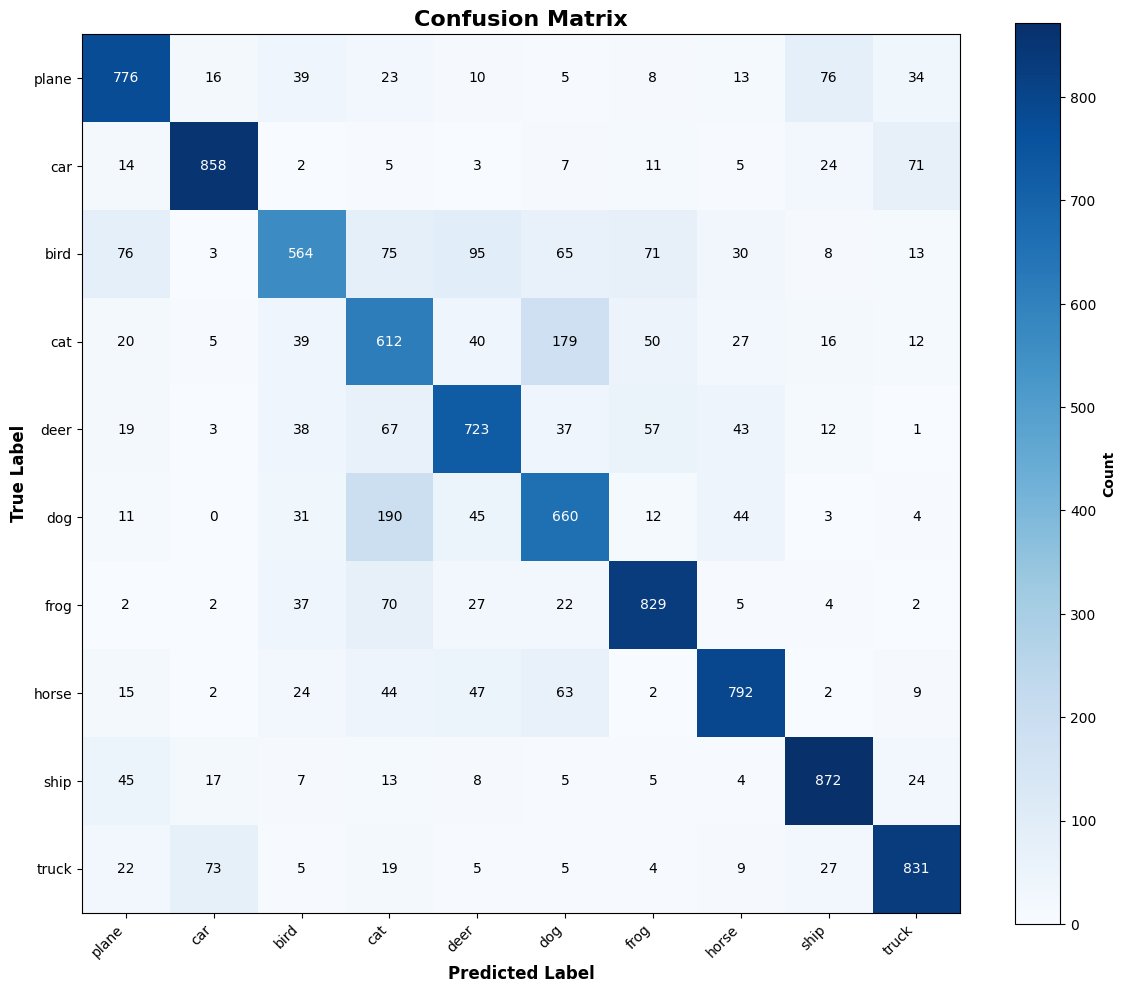

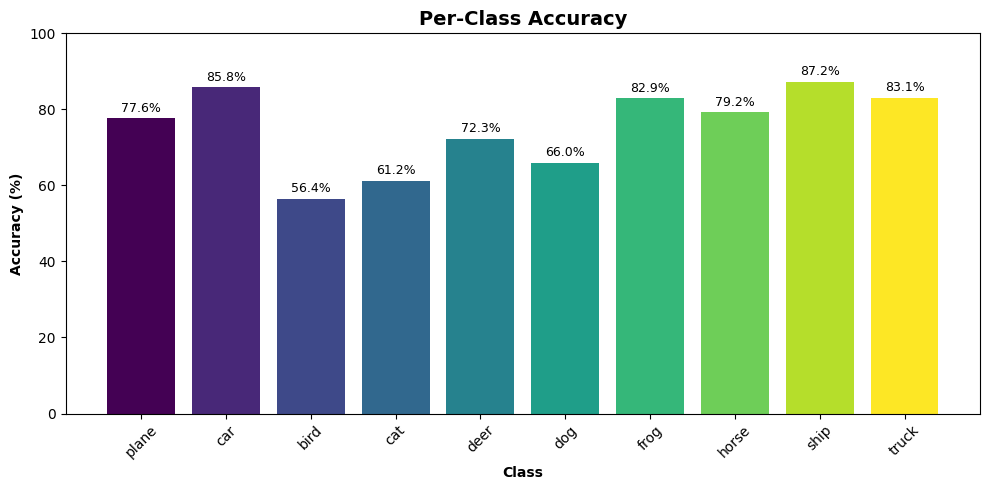

In [11]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(confusion, cmap='Blues')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Count', fontweight='bold')

# Labels and ticks
ax.set_xticks(range(10))
ax.set_yticks(range(10))
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_yticklabels(classes)
ax.set_xlabel('Predicted Label', fontweight='bold', fontsize=12)
ax.set_ylabel('True Label', fontweight='bold', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=16, fontweight='bold')

# Add text annotations
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, str(confusion[i, j]),
                      ha="center", va="center", color="black" if confusion[i, j] < confusion.max()/2 else "white")

plt.tight_layout()
plt.show()

# Per-class accuracy bar chart
fig, ax = plt.subplots(figsize=(10, 5))

# Compute per-class accuracy
per_class_accuracy = []
for i in range(len(classes)):
    class_total = confusion[i].sum()
    acc = confusion[i, i] / class_total if class_total > 0 else 0.0
    per_class_accuracy.append(acc * 100)

colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
ax.bar(range(len(classes)), per_class_accuracy, color=colors)

# Labels and formatting
ax.set_xlabel('Class', fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontweight='bold')
ax.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=45)
ax.set_ylim(0, 100)

for i, acc in enumerate(per_class_accuracy):
    ax.text(i, acc + 1, f"{acc:.1f}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

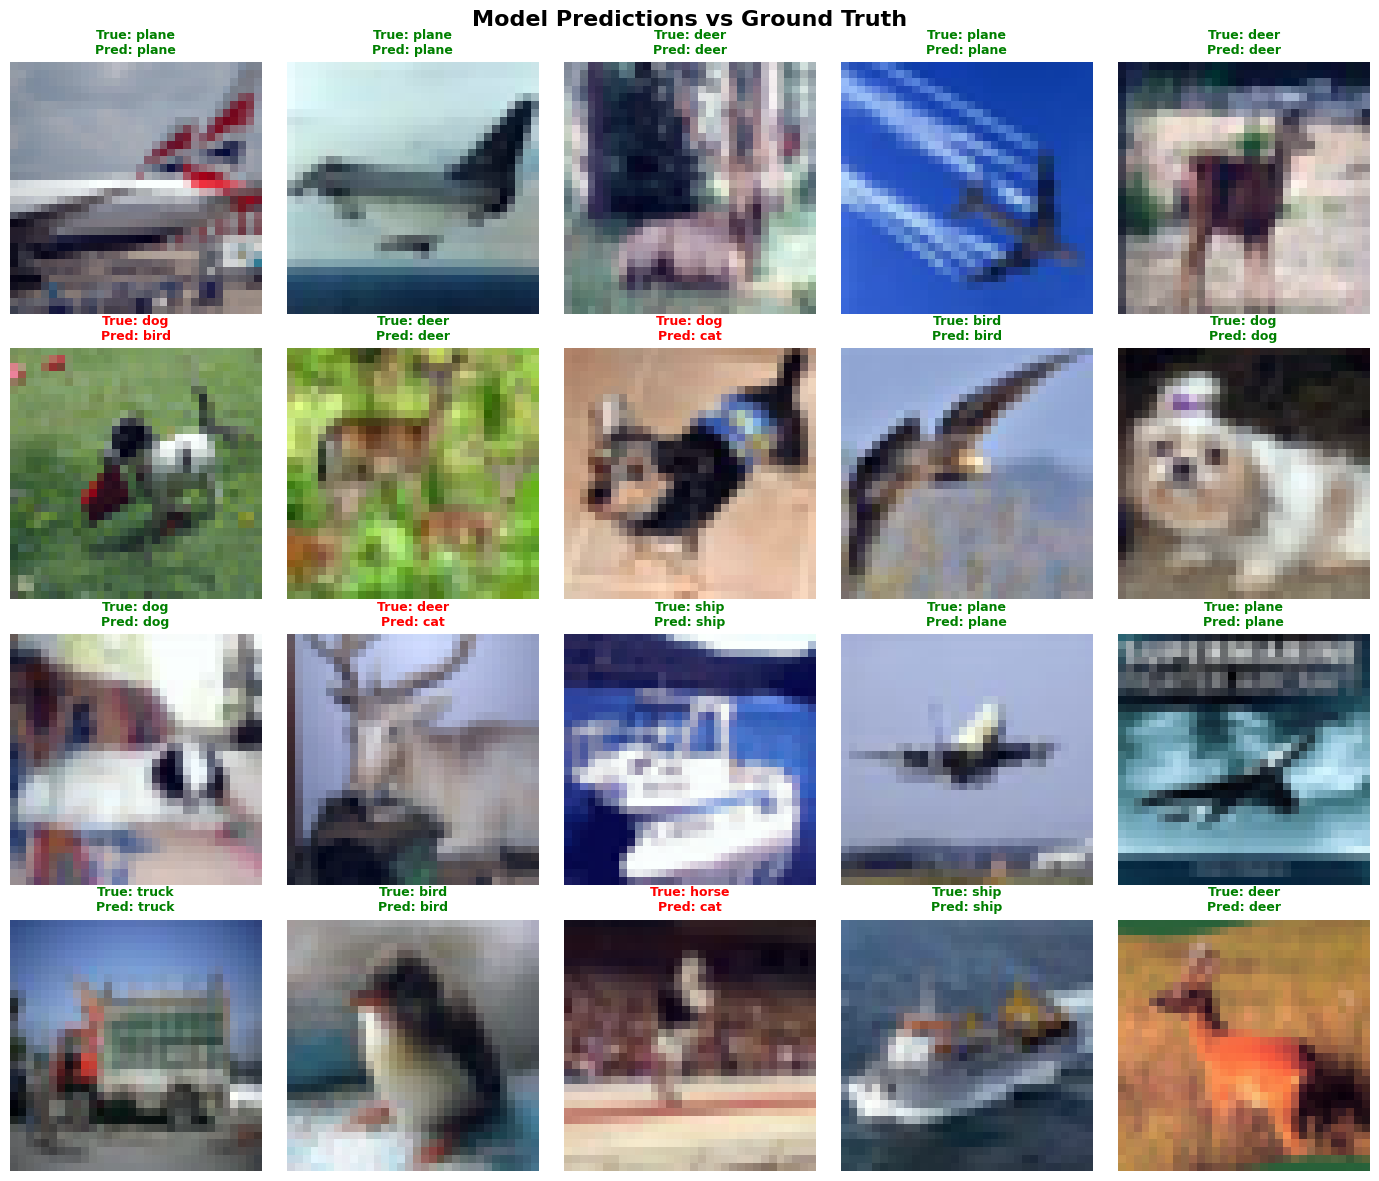

In [12]:
# Show prediction examples
import cupy as cp
def show_predictions(model, data, labels, classes, device="cpu", num_images=20):
    model.eval()

    indices = np.random.choice(len(data), num_images, replace=False)

    sample_x = Tensor(data[indices].astype(np.float32), requires_grad=False, device=device)
    sample_y = labels[indices].astype(int)

    with no_grad():
        logits = model(sample_x)
        pred = logits.data.argmax(axis=1)

    pred = cp.asnumpy(pred).astype(int)

    fig, axes = plt.subplots(4, 5, figsize=(14, 12))
    fig.suptitle("Model Predictions vs Ground Truth", fontsize=16, fontweight="bold")

    for idx, ax in enumerate(axes.flat):
        img = data[indices[idx]].transpose(1, 2, 0)  # CHW -> HWC
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)

        ax.imshow(img)

        true_label = classes[sample_y[idx]]
        pred_label = classes[pred[idx]]
        color = "green" if true_label == pred_label else "red"

        ax.set_title(f"True: {true_label}\nPred: {pred_label}",
                     fontsize=9, fontweight="bold", color=color)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_predictions(model, val_data, val_labels, classes, device="cuda")